## Word count analysis over time

In [1]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import CHAPTERS_DATA_TSV

In [2]:
def count_words(s: str):
    return len(s.split())

In [3]:
def words_per_second(row: pd.Series) -> float | None:
    n_words = row["word_count"]
    duration_s = row["duration_sec"]

    if pd.notna(duration_s) or pd.notna(n_words):
        return n_words / duration_s
    else:
        return None


def get_duration_sec(row: pd.Series) -> float | None:
    start_ms = row["start"]
    end_ms = row["end"]

    if pd.notna(start_ms) or pd.notna(end_ms):
        duration_sec = (float(end_ms) - float(start_ms)) / 1000
        return duration_sec
    else:
        return None

In [4]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Filter data

# Only data with timestamps
df = df[(df["start"].notna()) & (df["end"].notna())]
# Only military
df = df[(df["is_combat_scene"].notna()) & (df["is_combat_scene"])]

df["word_count"] = df["audio_transcription"].apply(count_words)
df["duration_sec"] = df.apply(lambda row: get_duration_sec(row), axis=1)
df["word_count_per_second"] = df.apply(lambda row: words_per_second(row), axis=1)

In [5]:
df["word_count_per_second"].describe()

count    678.000000
mean       0.814349
std        0.360312
min        0.121739
25%        0.590720
50%        0.750598
75%        0.973684
max        3.428571
Name: word_count_per_second, dtype: float64

In [6]:
df["word_count_per_minute"] = df["word_count_per_second"]*60

In [7]:
episode_median = (
    df
    .groupby(['episode', "year"], as_index=False)
    ['word_count_per_minute']
    .median()
)
episode_median

,episode,year,word_count_per_minute
0,511,1940,58.123667
1,512,1940,51.502146
2,513,1940,81.600000
3,514,1940,35.736677
4,515,1940,29.912023
...,...,...,...
175,744,1944,66.042254
176,745,1944,56.783217
177,746,1944,82.105263
178,747,1945,65.025895


In [8]:
from scipy.stats import pearsonr, spearmanr

x = df['episode']
y = df['word_count_per_minute']

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)

pearson_r, pearson_p, spearman_r, spearman_p


(np.float64(0.18466952263871442),
 np.float64(1.2897208067380467e-06),
 np.float64(0.21645005422581015),
 np.float64(1.2464606808152216e-08))

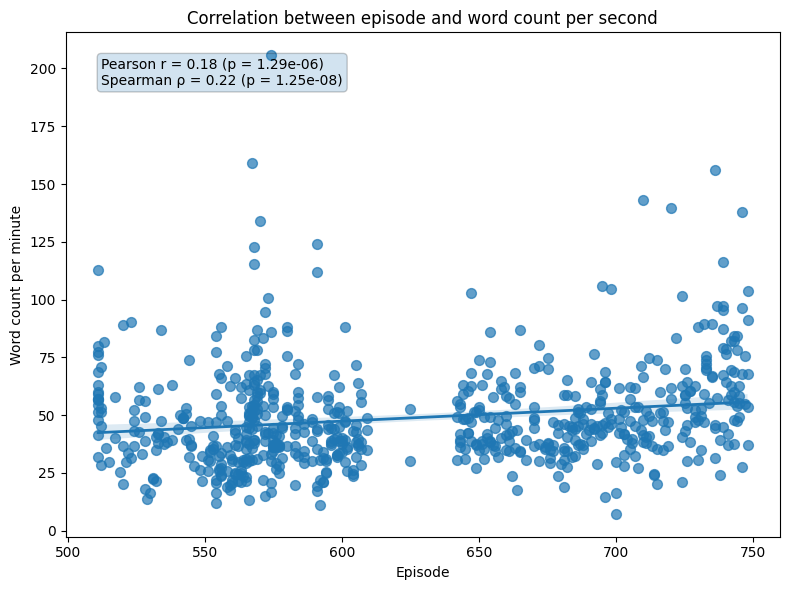

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sns.regplot(
    data=df,
    x='episode',
    y='word_count_per_minute',
    scatter_kws={'alpha': 0.7, 's': 50},
    line_kws={'linewidth': 2}
)

plt.xlabel("Episode")
plt.ylabel("Word count per minute")
plt.title("Correlation between episode and word count per second")

# add correlation text
text = (
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3g})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3g})"
)

plt.text(
    0.05, 0.95,
    text,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.2)
)

plt.tight_layout()
plt.show()


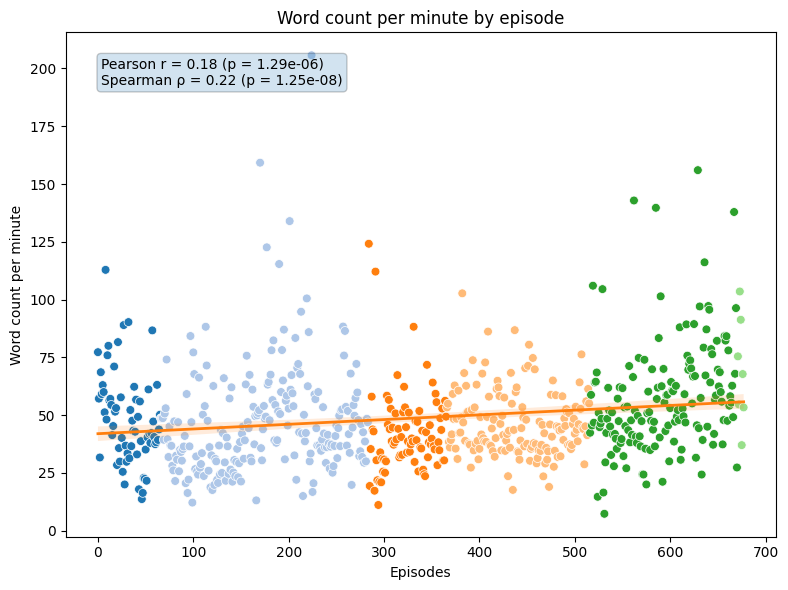

In [10]:
df_sorted = df.sort_values('episode').reset_index(drop=True)


text = (
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3g})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3g})"
)

plt.figure(figsize=(8, 6))

sns.lineplot(
    data=df_sorted,
    x=df_sorted.index,
    y='word_count_per_minute',
    linewidth=0,
    alpha=0.7
)

sns.scatterplot(
    data=df_sorted,
    x=df_sorted.index,
    y='word_count_per_minute',
    hue='year',
    palette='tab20',
    legend=False,
    s=40
)


# LOWESS trendline
sns.regplot(
    x=df_sorted.index,
    y=df_sorted['word_count_per_minute'],
    scatter=False,
    line_kws={'linewidth': 2}
)

plt.text(
    0.05, 0.95,
    text,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.2)
)


plt.xlabel("Episodes")
plt.ylabel("Word count per minute")
plt.title("Word count per minute by episode")

plt.tight_layout()
plt.show()


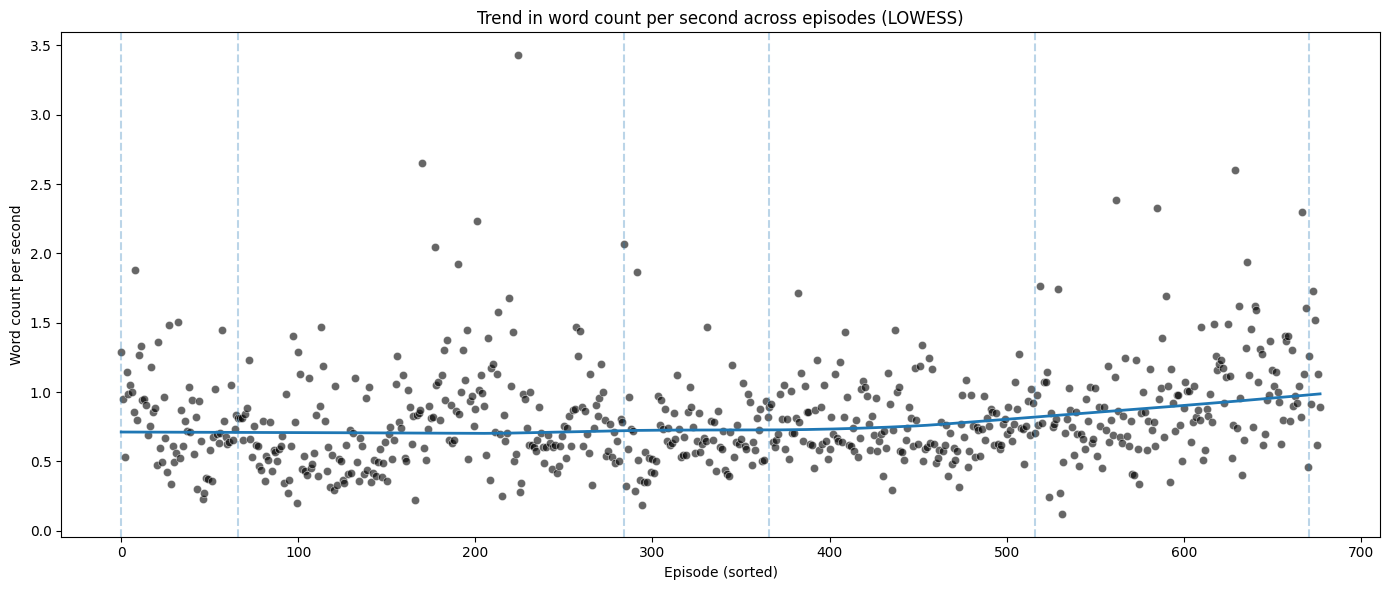

In [11]:
df_sorted = df.sort_values('episode').reset_index(drop=True)

plt.figure(figsize=(14, 6))

# scatter
sns.scatterplot(
    x=df_sorted.index,
    y=df_sorted['word_count_per_second'],
    color='black',
    s=35,
    alpha=0.6
)

# LOWESS trendline
sns.regplot(
    x=df_sorted.index,
    y=df_sorted['word_count_per_second'],
    scatter=False,
    lowess=True,
    line_kws={'linewidth': 2}
)

# year boundaries
year_changes = df_sorted['year'].ne(df_sorted['year'].shift())
for idx in df_sorted.index[year_changes]:
    plt.axvline(idx, linestyle='--', alpha=0.3)

plt.xlabel("Episode (sorted)")
plt.ylabel("Word count per second")
plt.title("Trend in word count per second across episodes (LOWESS)")

plt.tight_layout()
plt.show()